In [76]:
import csv

import pandas as pd
import numpy as np
import sqlite3
from os import path
import matplotlib.pyplot as plot

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [102]:
db_path = path.join("..", "db.sqlite3")
connect = sqlite3.connect(db_path)
db = connect.cursor()
first_table = db.execute(
    """
    SELECT restaurant_orderitem.id, restaurant_order.id AS order_id,restaurant_order.datetime AS order_datetime, restaurant_product.name AS product, restaurant_product.price AS product_price, restaurant_orderitem.quantity
    FROM restaurant_orderitem
    INNER JOIN restaurant_order ON restaurant_orderitem.order_id=restaurant_order.id
    INNER JOIN restaurant_product ON restaurant_orderitem.product_id=restaurant_product.id
    """
)
result_rows = first_table.fetchall()
with open(path.join("..", "orders.csv"), "w") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "order_id", "order_datetime", "product", "product_price", "quantity"])
    writer.writerows(result_rows)

db.close()

df = pd.read_csv(path.join("..", "orders.csv"), index_col=[0])
df["order_datetime"] = pd.to_datetime(df["order_datetime"], format="%Y-%m-%d %H:%M:%S")

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [ ]:
most_popular_products = df.groupby("product")["quantity"].sum().sort_values(ascending=False)[:10]
total = most_popular_products.sum()
most_popular_products.plot.pie(autopct = lambda p: "{:.1f}%({:.0f})".format(p,(p/100)*total), figsize=(10, 8))

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

In [ ]:
df["item_price"] = df["product_price"] * df["quantity"]
most_profit_products = df.groupby("product")["item_price"].sum().sort_values(ascending=False)[:10]
total_profit = most_profit_products.sum()
most_profit_products.plot.pie(autopct = lambda p: "{:.1f}%({:.0f})".format(p,(p/100)*total_profit), figsize=(10, 8))

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

In [ ]:
df["order_hour"] = df["order_datetime"].dt.hour
df.groupby("order_hour")["item_price"].sum().plot.bar(figsize=(14, 6))

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<Axes: xlabel='day_of_week'>

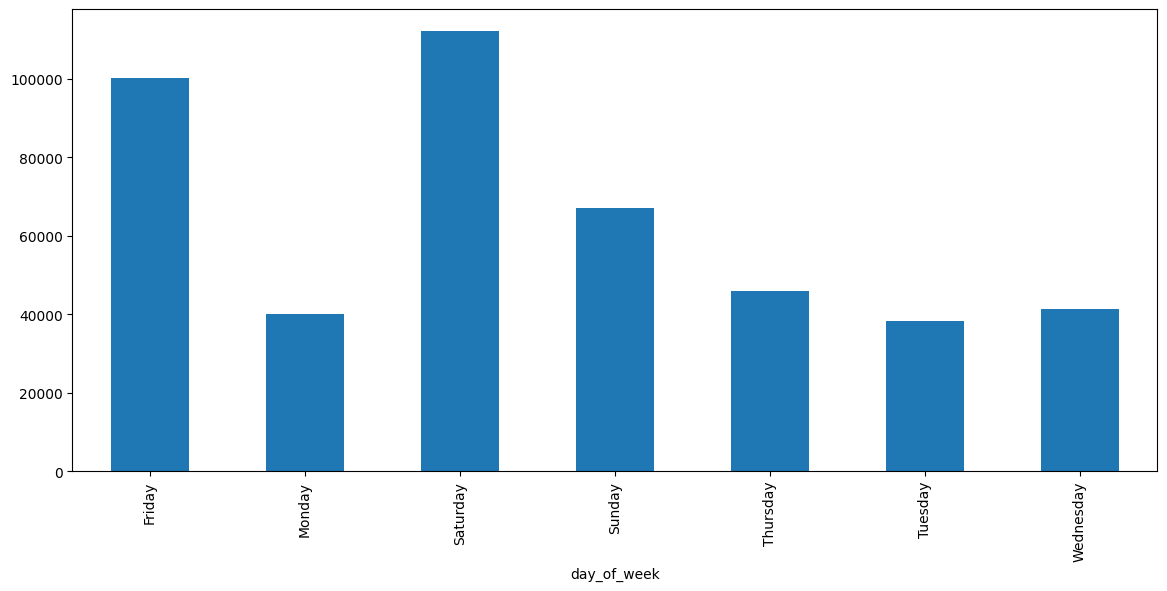

In [109]:
df["day_of_week"] = df["order_datetime"].dt.day_name()
df.groupby("day_of_week")["item_price"].sum().plot.bar(figsize=(14, 6))